In [48]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy
import numpy as np
import datetime as dt

In [2]:
DATA_PATH = 'D:/data'

In [3]:
%%time
apcp = xr.open_dataset(f'{DATA_PATH}/1844/means/apcp.1844.nc')
apcp_spreads = xr.open_dataset(f'{DATA_PATH}/1844/spreads/apcp.1844.nc')

CPU times: total: 266 ms
Wall time: 2.72 s


In [4]:
apcp

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 2928)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1844-01-01 ... 1844-12-31T21:00:00
Data variables:
    apcp     (time, lat, lon) float32 ...
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     8x Daily NOAA/CIRES/DOE 20th Century Reanalysi...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

In [5]:
%%time
min_lon = -114.91 % 360
min_lat = 27.98 
max_lon = -75.78 % 360
max_lat = 50.38 

cropped_apcp = apcp.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_apcp_spreads = apcp_spreads.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

CPU times: total: 15.6 ms
Wall time: 1.99 ms


In [6]:
def crop_nc(netcdf, min_lon = 245.09, min_lat = 27.98, max_lon = 284.22, max_lat = 50.38):
    return netcdf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

In [7]:
%%time
relative_error_apcp = (cropped_apcp_spreads['apcp'].sel(time=dt.datetime(1844,1,1))/np.sqrt(80))/cropped_apcp['apcp'].sel(time=dt.datetime(1844,1,1))
lon = cropped_apcp['lon']
lat = cropped_apcp['lat']

CPU times: total: 15.6 ms
Wall time: 14.9 ms


In [8]:
def get_rel_error_at_time(mean, spread, time, sample_size=80):
    return (spread.sel(time=time)/np.sqrt(sample_size))/mean.sel(time=time)

Text(0.5, 1.0, 'Absolute standard error in accululated precipitation on October 1st 1844')

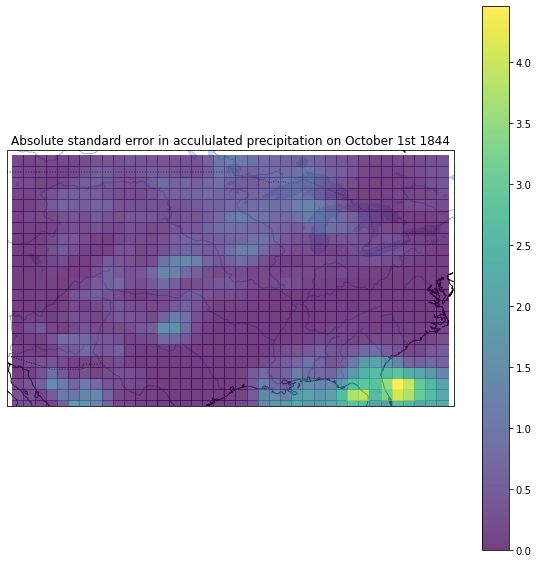

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-115, -75, 28, 51], crs=ccrs.PlateCarree())
im = ax.pcolor(lon, lat, cropped_apcp_spreads['apcp'].sel(time=dt.datetime(1844, 10,1)), alpha=0.75)
plt.colorbar(im)
ax.set_title('Absolute standard error in accululated precipitation on October 1st 1844')

Text(0.5, 1.0, 'Relative standard error in accululated precipitation on October 1st 1844')

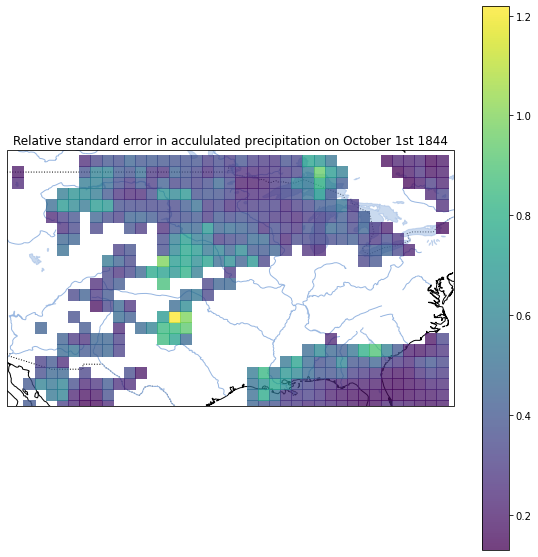

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-115, -75, 28, 51], crs=ccrs.PlateCarree())
im = ax.pcolor(lon, lat, get_rel_error_at_time(cropped_apcp['apcp'], cropped_apcp_spreads['apcp'], dt.datetime(1844, 10,1)), alpha=0.75)
plt.colorbar(im)
ax.set_title('Relative standard error in accululated precipitation on October 1st 1844')

In [24]:
def make_error_plots(varname, datetime, level=None, path=None, min_lon = 250.09, min_lat = 27.98, max_lon = 284.22, max_lat = 55):
    if path is None:
        path = f'D:/data/{datetime.year}'
        
    var_mean_full = xr.open_dataset(f'{path}/means/{varname}.{datetime.year}.nc')
    var_spread_full = xr.open_dataset(f'{path}/spreads/{varname}.{datetime.year}.nc')
    
    var_mean = crop_nc(var_mean_full, min_lon, min_lat, max_lon, max_lat)
    var_spread= crop_nc(var_spread_full, min_lon, min_lat, max_lon, max_lat)
    
    if varname in ['hgt', 'uwnd', 'vwnd']:
        var_mean = var_mean.sel(level=level)
        var_spread = var_spread.sel(level=level)
    
    lon = var_mean['lon']
    lat = var_mean['lat']
    
    fig = plt.figure(figsize=(10,30))
    ax3 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax3.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax3.add_feature(cartopy.feature.RIVERS)
    ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im3 = ax3.pcolor(lon, lat, var_mean[varname].sel(time=datetime), alpha=0.75)
    plt.colorbar(im3)
    ax3.set_title(f'{varname} on {datetime}')

    ax1 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax1.add_feature(cartopy.feature.RIVERS)
    ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im = ax1.pcolor(lon, lat, get_rel_error_at_time(var_mean[varname], var_spread[varname], datetime), alpha=0.75)
    plt.colorbar(im)
    ax1.set_title(f'Relative error in {varname} on {datetime}')
    
    ax2 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.COASTLINE)
    ax2.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax2.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax2.add_feature(cartopy.feature.RIVERS)
    ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    im2 = ax2.pcolor(lon, lat, var_spread[varname].sel(time=datetime)/np.sqrt(80), alpha=0.75)
    plt.colorbar(im2)
    ax2.set_title(f'Absolute standard error in {varname} on {datetime}')

CPU times: total: 312 ms
Wall time: 315 ms


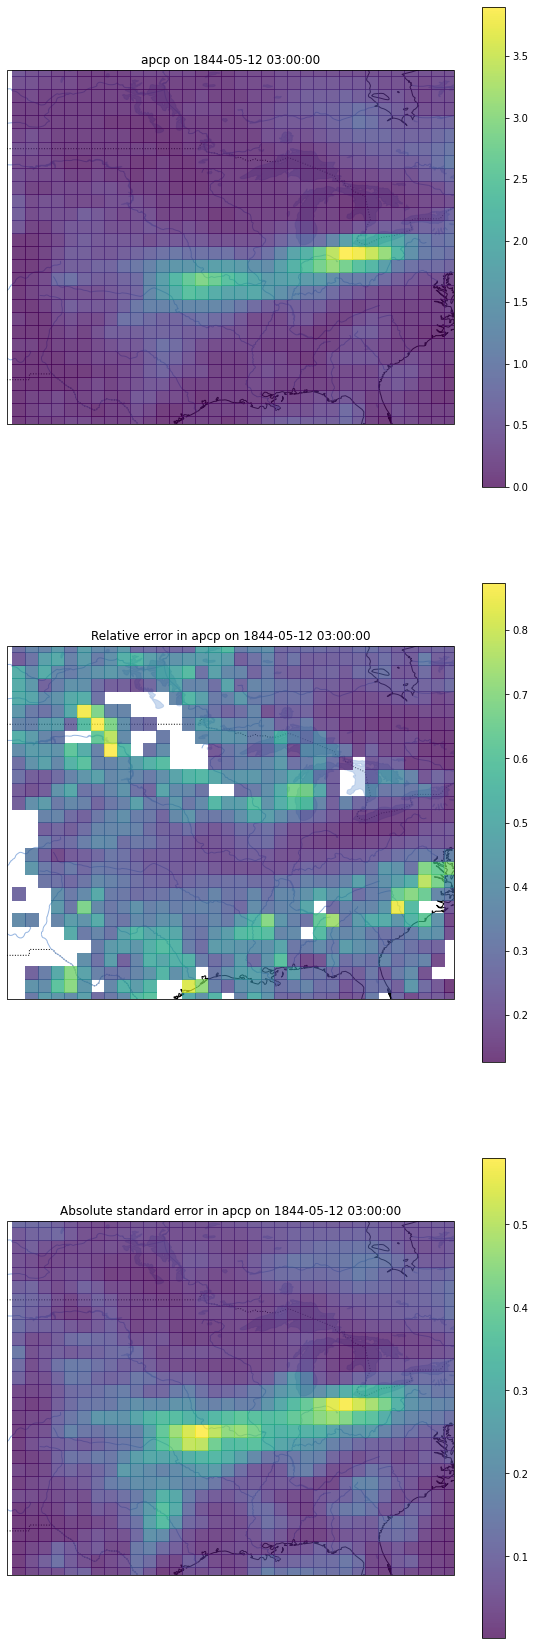

In [35]:
%%time
make_error_plots('apcp', dt.datetime(1844, 5, 12, 3), level=1000)

In [49]:
def make_storm_animation(varname, datetime, level=None, path=None, min_lon = 250.09, min_lat = 27.98, max_lon = 284.22, max_lat = 55):
    if path is None:
        path = f'D:/data/{datetime.year}'
        
    var_mean_full = xr.open_dataset(f'{path}/means/{varname}.{datetime.year}.nc')
    var_spread_full = xr.open_dataset(f'{path}/spreads/{varname}.{datetime.year}.nc')
    
    var_mean = crop_nc(var_mean_full, min_lon, min_lat, max_lon, max_lat)
    var_spread= crop_nc(var_spread_full, min_lon, min_lat, max_lon, max_lat)
    
    if varname in ['hgt', 'uwnd', 'vwnd']:
        var_mean = var_mean.sel(level=level)
        var_spread = var_spread.sel(level=level)
    
    lon = var_mean['lon']
    lat = var_mean['lat']
    
    fig = plt.figure(figsize=(10,10))
    ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax3.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax3.add_feature(cartopy.feature.RIVERS)
    ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    def plot_storm(steps_plus):
    
        im3 = ax3.pcolor(lon, lat, var_mean[varname].sel(time=datetime + dt.timedelta(hours = 3 * steps_plus)), alpha=0.75)
        cbar = plt.colorbar(im3)
        return [im3, cbar]
    
    anim = FuncAnimation(fig, plot_storm)
    plt.show()
    
    ax3.set_title(f'{varname} on {datetime}')

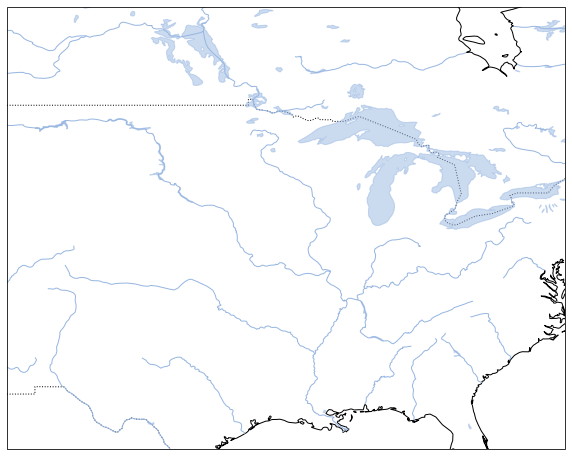

CPU times: total: 125 ms
Wall time: 121 ms


C:\Users\bpara\anaconda3\envs\esslab\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [50]:
%%time
make_storm_animation('apcp', dt.datetime(1844, 5, 12, 3), level=1000)

In [54]:
import storm_animation